In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
car_train=pd.read_csv("../data/train.csv")
car_test=pd.read_csv("../data/test.csv")

In [4]:
#since the discount column is missing in both train and test set lets remove that column
car_train = car_train.drop(['Descuento', 'id'],axis=1)
car_test = car_test.drop(['Descuento'],axis=1)
# Probar a rellenar
car_train = car_train.dropna()
car_test = car_test.dropna()

In [5]:
car_train_orig = car_train.copy()
car_test_orig =  car_test.copy()

In [6]:
for i in list(car_train.columns):
    if car_train[i].dtypes == "object":
        to_read = "../data/" + i.lower() + ".csv"
        label = LabelEncoder().fit(pd.read_csv(to_read)[i])
        car_train[i] = label.transform(car_train_orig[i])
        car_test[i] = label.transform(car_test_orig[i])

In [7]:
car_train.head()

,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Precio_cat
0,1143,5,2012.0,83000.0,1,1,0,353,14,299,5.0,3
1,1204,7,2016.0,4800.0,4,1,0,290,144,279,5.0,3
2,846,4,2016.0,26000.0,1,1,0,377,11,308,6.0,3
3,714,3,2013.0,56127.0,4,1,0,235,10,312,5.0,3
4,472,6,2017.0,41981.0,4,1,0,242,12,344,5.0,3


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [9]:
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [10]:
y = car_train['Precio_cat']
X = car_train.drop(['Precio_cat'],axis=1)

In [11]:
X, y = RandomOverSampler(random_state = 42).fit_resample(X, y)

In [12]:
# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

/Users/davidalbertomartinvela/opt/anaconda3/envs/Kaggle/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [13]:
enc.fit_transform(y[:, np.newaxis]).toarray()

/Users/davidalbertomartinvela/opt/anaconda3/envs/Kaggle/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [14]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5, random_state=2)

# n_features = X.shape[1]
# n_samples = X.shape[0]
n_features = X.shape[1]
n_samples = X_train.shape[0]
n_classes = Y.shape[1]
print("Number of features:", n_features)
print("Number of samples:", n_samples)
print("Number of classes to predict:", n_classes)

Number of features: 11
Number of samples: 4562
Number of classes to predict: 5


In [16]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras.layers import Dense

In [17]:
def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        for i in range(n):
            model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
        model.add(Dense(output_dim, activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        return model
    return create_model

In [18]:
alpha = 5
nodes = n_samples // (alpha * (n_features + n_classes))
print("Number of nodes:", nodes)
models = [create_custom_model(n_features, n_classes, nodes, i, 'model_{}'.format(i)) 
          for i in range(1, 6)]

for create_model in models:
    create_model().summary()

Number of nodes: 57
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 57)                684       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 290       
Total params: 974
Trainable params: 974
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 57)                684       
_________________________________________________________________
dense_4 (Dense)              (None, 57)                3306      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 290       
Total params: 4,280
Trainable params: 4,280
Non-trainable 

In [19]:
from keras.callbacks import TensorBoard

history_dict = {}

# TensorBoard Callback
cb = TensorBoard()

for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_dict[model.name] = [history_callback, model]

Model name: model_1
Test loss: 0.5242504156030324
Test accuracy: 0.7931185623101438
Model name: model_2
Test loss: 0.4219926933486708
Test accuracy: 0.8652202497703214
Model name: model_3
Test loss: 0.46052292336791645
Test accuracy: 0.8834100371908781
Model name: model_4
Test loss: 0.481201255880582
Test accuracy: 0.8869165023272428
Model name: model_5
Test loss: 0.47377978864858844
Test accuracy: 0.8829717292170135


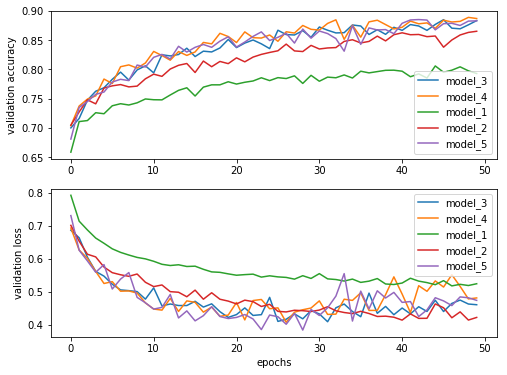

In [20]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_acc = history_dict[model_name][0].history['val_acc']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_acc, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

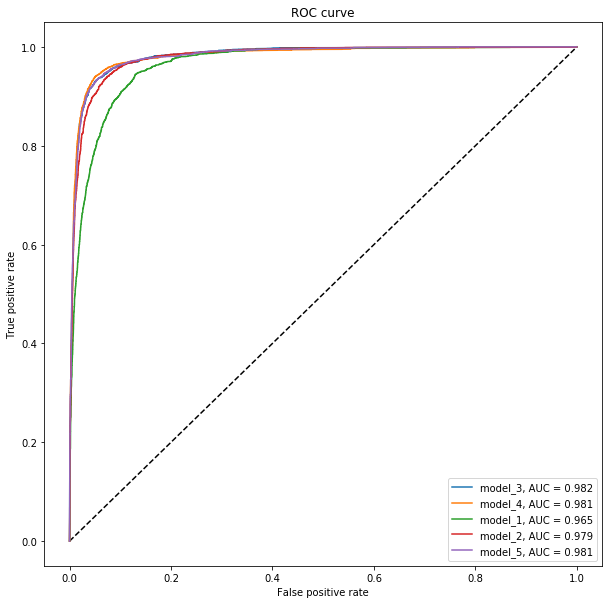

In [21]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

for model_name in history_dict:
    model = history_dict[model_name][1]
    
    Y_pred = model.predict(X_test)
    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
    
    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(model_name, auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [22]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

create_model = create_custom_model(n_features, n_classes, nodes, 2)

estimator = KerasClassifier(build_fn=create_model, epochs=50, batch_size=5, verbose=0)

In [23]:
scores = cross_val_score(estimator, X_train, Y_train, cv=10)
print("Accuracy : {:0.3f} (+/- {:0.3f})".format(scores.mean(), scores.std()))

Accuracy : 0.855 (+/- 0.012)


In [24]:
estimator.fit(X_train, Y_train,
             batch_size=5,
             epochs=50,
             verbose=0,
             validation_data=(X_test, Y_test),
             callbacks=[cb])

In [25]:
tests_ids = car_test['id']
del car_test['id']

In [26]:
test_scaled = scaler.transform(car_test)

/Users/davidalbertomartinvela/opt/anaconda3/envs/Kaggle/lib/python3.5/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [27]:
predict = estimator.predict(test_scaled)

In [45]:
print(predict)

[5 2 2 ... 5 5 5]


In [46]:
submit = pd.read_csv('../data/sample.csv')
submit['Precio_cat'] = predict
submit.to_csv('mis_resultados_nn.csv', index=False)